Transfer Learning with VGG16 model. Using data balancing technique of subsetting majority and resampling minority, data is fed into the model and prediction accuracy is evaluated 

In [ ]:
#import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import seaborn as sns
from PIL import Image
import tensorflow as tf
from google.colab import drive
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical 
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, GlobalAveragePooling2D, ZeroPadding2D
from keras.applications import vgg16
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_metadata_gc.zip'

Archive:  /content/drive/MyDrive/HAM10000_metadata_gc.zip
  inflating: HAM10000_metadata       


In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_1_gc'

In [ ]:
! unzip '/content/drive/MyDrive/HAM10000_images_part_2_gc'

In [ ]:
md = pd.read_csv("/content/HAM10000_metadata")
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


In [ ]:
#vgg16 model accepts images of 224X224X3
im_size = 224

In [ ]:
#label encoding: going from text to numerical
lab_enc = LabelEncoder()
lab_enc.fit(md['dx'])
LabelEncoder()
print(list(lab_enc.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
#label column in md - diagnosis and numerical label in one dataset
md['label'] = lab_enc.transform(md["dx"]) 

md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0


In [ ]:
#get all file paths and make a new column
fldr1 = '/content/HAM10000_images_part_1'
fldr2 = '/content/HAM10000_images_part_2'

im_paths = []

for i in md['image_id']:
  fid = i

  fn = '/' + fid + '.jpg'

  if os.path.isfile(fldr1 + fn) == True:
    im_paths.append(fldr1+fn)
  else:
    im_paths.append(fldr2+fn)

In [ ]:
md['image_paths'] = im_paths

In [ ]:
md

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,2,/content/HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2,/content/HAM10000_images_part_2/ISIC_0031633.jpg
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033084.jpg
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033550.jpg
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0033536.jpg
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,0,/content/HAM10000_images_part_2/ISIC_0032854.jpg


In [ ]:
#seperate data into diagnoses
dx_0 = md[md['label'] == 0]
dx_1 = md[md['label'] == 1]
dx_2 = md[md['label'] == 2]
dx_3 = md[md['label'] == 3]
dx_4 = md[md['label'] == 4]
dx_5 = md[md['label'] == 5]
dx_6 = md[md['label'] == 6]

In [ ]:
from pandas.core.common import random_state
#subset and random resample of data by diagnosis
n = 1000
dx_0_balanced = resample(dx_0, replace=True, n_samples=n, random_state=29) 
dx_1_balanced = resample(dx_1, replace=True, n_samples=n, random_state=29) 
dx_2_balanced = resample(dx_2, replace=True, n_samples=n, random_state=29)
dx_3_balanced = resample(dx_3, replace=True, n_samples=n, random_state=29)
dx_4_balanced = resample(dx_4, replace=True, n_samples=n, random_state=29)
dx_5_balanced = resample(dx_5, replace=True, n_samples=n, random_state=29)
dx_6_balanced = resample(dx_6, replace=True, n_samples=n, random_state=29)

In [ ]:
md_balanced = pd.concat([dx_0_balanced, dx_1_balanced, dx_2_balanced, dx_3_balanced, dx_4_balanced, dx_5_balanced, dx_6_balanced])

md_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths
9923,HAM_0006434,ISIC_0028076,akiec,histo,60.0,male,lower extremity,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0028076.jpg
9721,HAM_0004012,ISIC_0030803,akiec,histo,65.0,female,face,rosendahl,0,/content/HAM10000_images_part_2/ISIC_0030803.jpg
9983,HAM_0006252,ISIC_0026040,akiec,histo,70.0,female,face,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0026040.jpg
9898,HAM_0000005,ISIC_0025577,akiec,histo,75.0,female,lower extremity,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0025577.jpg
9781,HAM_0000859,ISIC_0029715,akiec,histo,70.0,male,lower extremity,rosendahl,0,/content/HAM10000_images_part_2/ISIC_0029715.jpg
...,...,...,...,...,...,...,...,...,...,...
2421,HAM_0002788,ISIC_0027563,vasc,consensus,70.0,male,lower extremity,vidir_molemax,6,/content/HAM10000_images_part_1/ISIC_0027563.jpg
2373,HAM_0005989,ISIC_0031648,vasc,histo,25.0,female,back,vidir_modern,6,/content/HAM10000_images_part_2/ISIC_0031648.jpg
2334,HAM_0002218,ISIC_0025578,vasc,histo,5.0,male,back,vidir_modern,6,/content/HAM10000_images_part_1/ISIC_0025578.jpg
2413,HAM_0003873,ISIC_0024475,vasc,consensus,35.0,male,face,vidir_molemax,6,/content/HAM10000_images_part_1/ISIC_0024475.jpg


In [ ]:
#turn images to array and add as a new column 
md_balanced['image'] = md_balanced['image_paths'].map(lambda x: np.asarray(Image.open(x).resize((im_size,im_size))))

In [ ]:
md_balanced

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label,image_paths,image
9923,HAM_0006434,ISIC_0028076,akiec,histo,60.0,male,lower extremity,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0028076.jpg,"[[[160, 117, 113], [164, 117, 113], [166, 124,..."
9721,HAM_0004012,ISIC_0030803,akiec,histo,65.0,female,face,rosendahl,0,/content/HAM10000_images_part_2/ISIC_0030803.jpg,"[[[178, 130, 140], [176, 126, 135], [176, 124,..."
9983,HAM_0006252,ISIC_0026040,akiec,histo,70.0,female,face,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0026040.jpg,"[[[172, 148, 162], [170, 146, 159], [173, 145,..."
9898,HAM_0000005,ISIC_0025577,akiec,histo,75.0,female,lower extremity,rosendahl,0,/content/HAM10000_images_part_1/ISIC_0025577.jpg,"[[[198, 172, 173], [198, 173, 170], [198, 170,..."
9781,HAM_0000859,ISIC_0029715,akiec,histo,70.0,male,lower extremity,rosendahl,0,/content/HAM10000_images_part_2/ISIC_0029715.jpg,"[[[192, 169, 191], [190, 165, 190], [188, 162,..."
...,...,...,...,...,...,...,...,...,...,...,...
2421,HAM_0002788,ISIC_0027563,vasc,consensus,70.0,male,lower extremity,vidir_molemax,6,/content/HAM10000_images_part_1/ISIC_0027563.jpg,"[[[196, 139, 163], [199, 140, 164], [197, 139,..."
2373,HAM_0005989,ISIC_0031648,vasc,histo,25.0,female,back,vidir_modern,6,/content/HAM10000_images_part_2/ISIC_0031648.jpg,"[[[254, 245, 246], [253, 248, 246], [253, 246,..."
2334,HAM_0002218,ISIC_0025578,vasc,histo,5.0,male,back,vidir_modern,6,/content/HAM10000_images_part_1/ISIC_0025578.jpg,"[[[186, 171, 187], [190, 173, 190], [188, 171,..."
2413,HAM_0003873,ISIC_0024475,vasc,consensus,35.0,male,face,vidir_molemax,6,/content/HAM10000_images_part_1/ISIC_0024475.jpg,"[[[183, 115, 119], [185, 114, 119], [184, 117,..."


In [ ]:
#numpy array of all images scaled
X = np.asarray(md_balanced['image'].tolist())
X = X/255. 
Y= md_balanced['label']
Y_dx = to_categorical(Y, num_classes=7)

In [ ]:
#train/test split - 70/30 split

x_train, x_test, y_train, y_test = train_test_split(X, Y_dx, test_size=0.30, random_state=29)

In [ ]:
#GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#model

img_rows, img_cols = 224, 224 

vgg_mod = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#freeze last 4 layers
for layer in vgg_mod.layers:
    layer.trainable = False

In [ ]:
for (i,layer) in enumerate(vgg_mod.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
#top layers replaced by our own - 7 classes. Other layers used as is and as trained on Imagenet

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 

In [ ]:
num_classes = 7

FC_Head = lw(vgg_mod, num_classes)
model = Model(inputs = vgg_mod.input, outputs = FC_Head)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [ ]:
#training

batch_size = 16 
epochs = 75

In [ ]:
mod_fit = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/75
307/307 - 18s - loss: 1.6849 - accuracy: 0.3220 - val_loss: 1.4865 - val_accuracy: 0.4014 - 18s/epoch - 58ms/step
Epoch 2/75
307/307 - 7s - loss: 1.4562 - accuracy: 0.4251 - val_loss: 1.5248 - val_accuracy: 0.4129 - 7s/epoch - 22ms/step
Epoch 3/75
307/307 - 7s - loss: 1.3203 - accuracy: 0.4861 - val_loss: 1.3384 - val_accuracy: 0.4767 - 7s/epoch - 22ms/step
Epoch 4/75
307/307 - 7s - loss: 1.2423 - accuracy: 0.5233 - val_loss: 1.2132 - val_accuracy: 0.5338 - 7s/epoch - 22ms/step
Epoch 5/75
307/307 - 7s - loss: 1.1818 - accuracy: 0.5541 - val_loss: 1.2093 - val_accuracy: 0.5462 - 7s/epoch - 22ms/step
Epoch 6/75
307/307 - 7s - loss: 1.1139 - accuracy: 0.5671 - val_loss: 1.1520 - val_accuracy: 0.5414 - 7s/epoch - 22ms/step
Epoch 7/75
307/307 - 7s - loss: 1.0649 - accuracy: 0.5973 - val_loss: 1.1294 - val_accuracy: 0.5657 - 7s/epoch - 22ms/step
Epoch 8/75
307/307 - 7s - loss: 1.0165 - accuracy: 0.6086 - val_loss: 1.1073 - val_accuracy: 0.5686 - 7s/epoch - 22ms/step
Epoch 9/75
307

In [ ]:
mod_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', mod_acc[1])

66/66 [==============================] - 3s 33ms/step - loss: 1.0635 - accuracy: 0.8205
Test accuracy: 0.8204761743545532


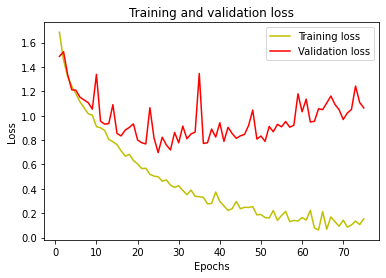

In [ ]:
loss = mod_fit.history['loss']
val_loss = mod_fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

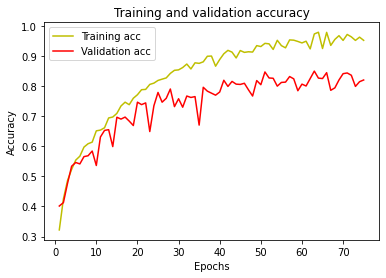

In [ ]:
acc = mod_fit.history['accuracy']
val_acc = mod_fit.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#predictions

y_pred = model.predict(x_test)

66/66 [==============================] - 2s 24ms/step


In [ ]:
#one hot encoding --> probs from softmax to 1 and 0
y_pred_classes = np.argmax(y_pred, axis = 1) 

In [ ]:
#same format as predictions
y_true = np.argmax(y_test, axis = 1) 

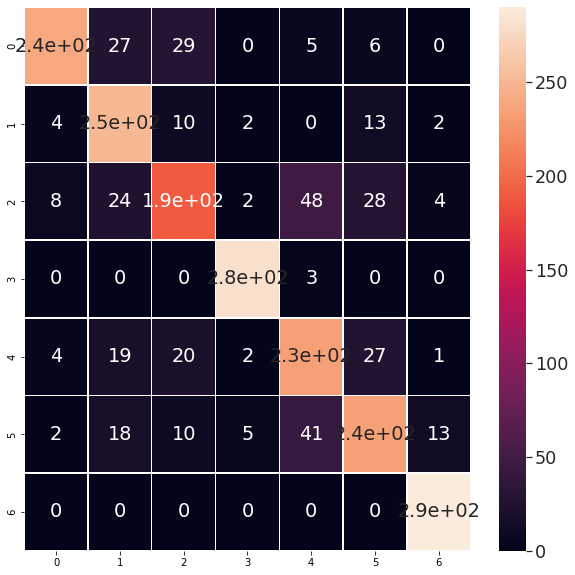

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [ ]:
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)

incorr_fraction = incorr_fraction.tolist()

incorr_fraction = [round(item, 2) for item in incorr_fraction]

incorr_fraction

[0.22, 0.11, 0.38, 0.01, 0.24, 0.27, 0.0]

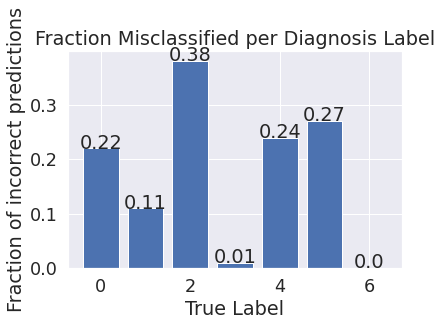

In [ ]:
#percent misclassified per dx
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
  
if __name__ == '__main__':
  plt.bar(np.arange(7), incorr_fraction)
  addlabels(np.arange(7), incorr_fraction)
  plt.title("Fraction Misclassified per Diagnosis Label")
  plt.xlabel('True Label')
  plt.ylabel('Fraction of incorrect predictions')

In [ ]:
#reference
#https://www.youtube.com/watch?v=Fxy6WTnUIww
#https://keras.io/api/layers/core_layers/dense/
#https://keras.io/api/models/model/
#https://www.educba.com/keras-fit/
#https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
